In [1]:
import numpy as np
from skimage import io, color, filters, morphology, feature, transform
from skimage.transform import hough_circle, hough_circle_peaks, probabilistic_hough_line
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.spatial.distance import euclidean
from scipy.ndimage import convolve1d

In [2]:
def load_and_preprocess(path, sigma=1.0, min_size=150):
    img = io.imread(path)
    # --- Alpha-Kanal entfernen, falls vorhanden ---
    if img.ndim == 3 and img.shape[2] == 4:
        # Variante A: einfach Alpha wegwerfen
        img = img[..., :3]
        # Oder Variante B: korrekt mischen
        # from skimage.color import rgba2rgb
        # img = rgba2rgb(img)

    # in Float [0,1] umwandeln
    img = img / 255.0 if img.dtype != np.float64 else img

    # Graustufen
    gray = color.rgb2gray(img)
    # Rest wie gehabt
    blurred = filters.gaussian(gray, sigma=sigma)
    thresh  = filters.threshold_otsu(blurred)
    binary  = blurred > thresh
    clean   = morphology.remove_small_objects(binary, min_size=min_size)
    return gray

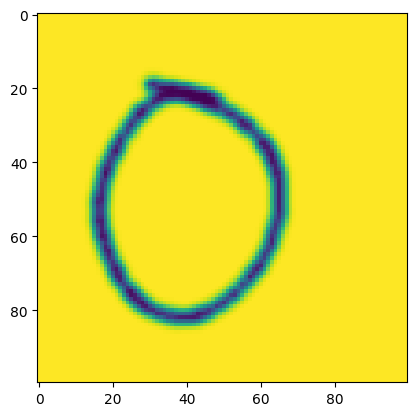

In [3]:
imgX = "../Ordner_des_ungeordneten/x1.png"
imgO = "../Ordner_des_ungeordneten/o1.png"
imgX = load_and_preprocess(imgX)
imgO = load_and_preprocess(imgO)

plt.imshow(imgX)
plt.imshow(imgO)
plt.show()

In [6]:
def harris_corners(I, H_px, H_py, H_dx, H_dy, H_bx, H_by, t_h, alpha=0.05, d_min=10):
    # 1. Pre-Filter (Glättung)
    I_smooth = convolve1d(I, H_px, axis=1)
    I_smooth = convolve1d(I_smooth, H_py[:, 0], axis=0)

    # 2. Ableitungen
    I_x = convolve1d(I_smooth, H_dx[0], axis=1)
    I_y = convolve1d(I_smooth, H_dy[:, 0], axis=0)

    # 3. Strukturmatrix-Komponenten
    A = I_x ** 2
    B = I_y ** 2
    C = I_x * I_y

    A_bar = convolve1d(A, H_bx, axis=1)
    A_bar = convolve1d(A_bar, H_by[:, 0], axis=0)

    B_bar = convolve1d(B, H_bx, axis=1)
    B_bar = convolve1d(B_bar, H_by[:, 0], axis=0)

    C_bar = convolve1d(C, H_bx, axis=1)
    C_bar = convolve1d(C_bar, H_by[:, 0], axis=0)

    # 4. Corner-Response-Funktion
    Q = (A_bar * B_bar - C_bar**2) - alpha * (A_bar + B_bar)**2

    # 5. Lokale Maxima extrahieren
    corners = []
    h, w = Q.shape
    for u in range(1, h - 1):
        for v in range(1, w - 1):
            if Q[u, v] > t_h and is_local_max(Q, u, v):
                corners.append((u, v, Q[u, v]))

    corners.sort(key=lambda x: x[2], reverse=True)
    good_corners = cleanup_neighbors(corners, d_min)
    return corners

def is_local_max(Q, u, v):
    q_c = Q[u, v]
    neighborhood = Q[u-1:u+2, v-1:v+2]
    return np.all(q_c >= neighborhood) and np.count_nonzero(q_c == neighborhood) == 1

def cleanup_neighbors(corners, d_min):
    good_corners = []
    while corners:
        c1 = corners.pop(0)
        good_corners.append(c1)
        corners = [c for c in corners if euclidean((c1[0], c1[1]), (c[0], c[1])) >= d_min]
    return good_corners

In [ ]:
import cv2

x = []
o = []
counterx = []
countero = []

H_px = np.array([2, 5, 2]) / 9.0
H_py = H_px.reshape(-1, 1)  # transponiert
H_dx = np.array([[-0.453014, 0.0, 0.453014]])
H_dy = H_dx.T
H_bx = np.array([1, 6, 15, 20, 15, 6, 1]) / 64.0
H_by = H_bx.reshape(-1, 1)


#cornersX = harris_corners(img, H_px, H_py, H_dx, H_dy, H_bx, H_by, t_h=25000, alpha=0.05, d_min=10)
#print(f"Anzahl der erkannten Ecken X: {len(cornersX)}")
# Visualisierung
#for u, v, q in cornersX:
 #   cv2.circle(imgX, (v, u), 2, (255, 0, 0), -1)
 
 
for i in range (1,6):
    imgx = load_and_preprocess(f"../Ordner_des_ungeordneten/x{i}.png")
    counterx.append(harris_corners(imgx, H_px, H_py, H_dx, H_dy, H_bx, H_by, t_h=25000, alpha=0.05, d_min=10))
    imgo = load_and_preprocess(f"../Ordner_des_ungeordneten/o{i}.png")
    countero.append(harris_corners(imgo, H_px, H_py, H_dx, H_dy, H_bx, H_by, t_h=25000, alpha=0.05, d_min=10))
    
print(f"Anzahl der erkannten Ecken X: {counterx}")
print(f"Anzahl der erkannten Ecken O: {countero}")



#cv2.imshow("Harris Corners", imgX)
#cv2.imshow("Harris Corners", imgO)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


TypeError: harris_corners() missing 1 required positional argument: 't_h'